In [1]:
import numpy as np
import pandas as pd
import re
import time
from datasketch import MinHash, MinHashLSHForest
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import model_report as mr
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
file_info = "C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\cleaned_combined_key_words_v1.csv"
df = pd.read_csv(file_info, sep='\t')

In [3]:
#balance classes
g = df.groupby('category')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

In [4]:
df.head()

url  code category language  \
category                                                                    
bu       0                    *://WWW.BKIDEAS.COM   200       bu       en   
         1  *://1085447.MARKETPLACE.TOPS.STONE.CC   200       bu       en   
         2                  *://betaeducation.org   200       bu       en   
         3              *://WWW.BAYPOINTLEGAL.COM   200       bu       en   
         4             *://WWW.KITTELSONCARPO.COM   200       bu       en   

                                                        title  \
category                                                        
bu       0                                                BKI   
         1  Crema Valencia - Exporters, Manufacturers, Sup...   
         2  IIT Foundation programme,Olympiad Course,VI to...   
         3  Bay Point Legal Service - Process Servers in S...   
         4  Doing Business in the Philippines | Business R...   

                                                      summary  \
category                                                        
bu       0         World Class Foodservice Industry Equipment   
         1  Crema Valencia - Exporters, Manufacturers, Sup...   
         2  IIT Foundation programme,Olympiad Course,VI to...   
         3  Bay Point Legal offers a wide variety of servi...   
         4  Kittelson & Carpo Consulting is a consulting f...   

                                                    key_words  \
category                                                        
bu       0  ('food service', 'service equipment', 'solutio...   
         1  ('crema valencia', 'valencia crema', 'granite ...   
         2  ('iit foundation', 'programme olympiad', 'clas...   
         3  ('point legal', 'bay point', 'service process'...   
         4  ('kittelson carpo', 'carpo consulting', 'busin...   

                                                      content  \
category                                                        
bu       0  Home Products cooking solutions Fryers, Tables...   
         1  1085447.Marketplace.Tops.stone.m.biz Granite M...   
         2  IIT Foundation programme,Olympiad Course,VI to...   
         3  Bay Point Legal Service Fast and Effective Pro...   
         4  Kittelson & Carpo Consulting Logo Flag PH (+63...   

                                                     combined  \
category                                                        
bu       0  BKI World Class Foodservice Industry Equipment...   
         1  Crema Valencia - Exporters, Manufacturers, Sup...   
         2  IIT Foundation programme,Olympiad Course,VI to...   
         3  Bay Point Legal Service - Process Servers in S...   
         4  Doing Business in the Philippines | Business R...   

                                                        nouns  \
category                                                        
bu       0  [('BKI', 0, 3, 'PROPN'), ('World', 4, 9, 'PROP...   
         1  [('Crema', 0, 5, 'PROPN'), ('Valencia', 6, 14,...   
         2  [('IIT', 0, 3, 'PROPN'), ('Foundation', 4, 14,...   
         3  [('Bay', 0, 3, 'PROPN'), ('Point', 4, 9, 'PROP...   
         4  [('Business', 6, 14, 'PROPN'), ('Philippines',...   

                                                    compounds  \
category                                                        
bu       0  [('BKI World Class Foodservice Industry Equipm...   
         1  [('Crema Valencia -', 0, 16, 'COMPOUND'), ('Co...   
         2  [('IIT Foundation programme', 0, 24, 'COMPOUND...   
         3  [('Bay Point Legal Service -', 0, 25, 'COMPOUN...   
         4  [('Philippines |', 22, 35, 'COMPOUND'), ('Busi...   

                                                   comp_nouns  \
category                                                        
bu       0  {'Hot', 'Sales', 'World', 'industry', 'wells',...   
         1  {'M.Biz', 'Pattern', 'Kitchen', 'slab', 'Compa...   
         2  {'Faculties', 'Enrichment', 'Designing', '

In [5]:
df.groupby(df.category).size()

category
bu    1595
dr    1595
ed    1595
mk    1595
os    1595
sp    1595
sx    1595
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
#get 10% holdout set
train_corpus, holdout_corpus, train_label, holdout_label = train_test_split(df['clean_key_words'], 
                                                                           df['category'],
                                                                           test_size=.10,random_state=1234)

#get 80% train and 20% test sets
train_corpus, test_corpus, train_label, test_label = train_test_split(train_corpus,
                                                                      train_label,
                                                                      test_size=.2225,random_state=1234) #.9 * .2225 = .20

train_corpus.shape, test_corpus.shape, holdout_corpus.shape

((7812,), (2236,), (1117,))

In [8]:
df_train = pd.DataFrame(zip(train_corpus,train_label),columns=["clean_key_words","label"])
df_test = pd.DataFrame(zip(test_corpus,test_label),columns=["clean_key_words","label"])
df_holdout = pd.DataFrame(zip(holdout_corpus,holdout_label),columns=["clean_key_words","label"])

In [9]:
df_train.head()

,clean_key_words,label
0,business plan financial support level comprehe...,bu
1,english honey honey english active manuka summ...,os
2,thai massage sen line call sen massage focus b...,mk
3,accurace timing time service cross country hig...,bu
4,medical technology europe middle east africa v...,bu


In [10]:
#Number of Permutations
permutations = 256


In [11]:
def preprocess(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

In [12]:
def get_forest(data,perms):
    start_time = time.time()
    minhash = []
    for text in data['clean_key_words']:
        tokens = preprocess(text)
        m = MinHash(num_perm=perms)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
    
    forest.index()
    
    print('It took %s seconds to build forest.' %(time.time()-start_time))
    
    return forest

In [19]:
def get_cosine(list1,list2):
    from collections import Counter

    # count word occurrences
    a_vals = Counter(list1)
    b_vals = Counter(list2)

    # convert to word-vectors
    words  = list(a_vals.keys() | b_vals.keys())
    a_vect = [a_vals.get(word, 0) for word in words]        
    b_vect = [b_vals.get(word, 0) for word in words]        

    # find cosine
    len_a  = sum(av*av for av in a_vect) ** 0.5             
    len_b  = sum(bv*bv for bv in b_vect) ** 0.5             
    dot    = sum(av*bv for av,bv in zip(a_vect, b_vect))    
    cosine = dot / (len_a * len_b)                          
    
    return cosine

In [20]:
def get_similars(test_item, database, perms, num_results, forest):
        
    tokens = preprocess(test_item)
    m = MinHash(num_perm=perms)
    for s in tokens:
        m.update(s.encode('utf8'))
    
    idx_array = np.array(forest.query(m, num_results))
    if len(idx_array) == 0:
        return None #if query is empty, return none
    
    #label = database.iloc[idx_array]['label']
    #text = database.iloc[idx_array]['clean_comp_nouns']
    df_results = pd.DataFrame(database.iloc[idx_array][['clean_key_words','label']])
    
    return df_results

In [21]:
def predict(test_item, database, perms, num_results, forest):
    df_pred = get_similars(test_item,df_train,permutations,num_similars,forest)
    df_pred['cos_dist'] = df_pred.apply(lambda x: get_cosine(preprocess(x['clean_key_words']),text),axis=1)
    
    return df_pred.sort_values('cos_dist',ascending=False)
    

In [22]:
def predict_one(test_item, database, perms, num_results, forest):
    df_pred_one = predict(test_item, database, perms, num_results, forest)
    #get most similar item based on cosine distance
    cat = None
    try:
        cat = df_pred_one.iloc[1, 1]
    except:
        cat = 'ed'
    
    return cat
    

In [23]:
def predict_mod(test_item, database, perms, num_results, forest):
    label = None
    try:
        df_pred_mod = get_similars(test_item,df_train,permutations,num_similars,forest)
        label = df_pred_mod['label'].value_counts()[:1].index.tolist()[0]
    except:
        return None
    return label

In [17]:
#build lsh forest using training data
forest = get_forest(df_train,permutations)

It took 16.288270711898804 seconds to build forest.


In [24]:
#Number of similars to return
num_similars = 50
test_item = 5
text = df_test['clean_key_words'][test_item]
#query the forest
df_predict = predict(text,df_train,permutations,num_similars,forest)
print('actual label: ',df_test['label'][test_item])
print('mod similar: ',predict_mod(text,df_train,permutations,num_similars,forest))
print('closest similar: ',predict_one(text,df_train,permutations,num_similars,forest))
print('All similars: ',predict(text,df_train,permutations,num_similars,forest))
text

actual label:  ed
mod similar:  mk
closest similar:  mk
All similars:                                          clean_key_words label  cos_dist
2305  hot tub spa hot tub care expect par hard knowl...    os       0.0
2405  gillingham dorset lick stick kennel gillingham...    mk       0.0
4683  asugsv summit start october education innovati...    bu       0.0
2516  long term term disability insurance denial add...    bu       0.0
1624  pet sitting winnipeg dog dog walk manitoba pet...    bu       0.0
6617  samsung medison medison samsung enhance premiu...    bu       0.0
3672  princeton public public school john witherspoo...    ed       0.0
6621  koi pond pond water garden fish spring koi fis...    os       0.0
2014  office general removal company furniture offic...    mk       0.0
3962  toxicology school education toxicology college...    ed       0.0
5089  view detail detail view point program zap zoni...    os       0.0
6115  child care slide show resource referral ccrr c...    ed    

'puchong kindergarten bukit puchong open day bandar bukit memory map education super preschool child mrc subject day session care hour'

In [25]:
df_results = pd.DataFrame(list(zip(df_test['clean_key_words'],df_test['label'])),columns=['terms','category'])
df_results['lsh_predict'] = df_results.apply(lambda x: predict_mod(x['terms'],df_train,permutations,num_similars,forest),axis=1)
df_results['match'] = np.where(df_results['category']==df_results['lsh_predict'],1,0)

In [26]:
df_results[df_results['lsh_predict'].isna()]

,terms,category,lsh_predict,match


In [27]:
rpt = mr.generate_report(df_results)
rpt

{'totalSamples': 2236,
 'overallAccuracy': 0.5053667262969589,
 'byCategory': {'sx': {'totalSamples': 332, 'accuracy': 0.8283132530120482},
  'dr': {'totalSamples': 331, 'accuracy': 0.6737160120845922},
  'sp': {'totalSamples': 318, 'accuracy': 0.5408805031446541},
  'ed': {'totalSamples': 330, 'accuracy': 0.45151515151515154},
  'bu': {'totalSamples': 311, 'accuracy': 0.3762057877813505},
  'mk': {'totalSamples': 300, 'accuracy': 0.35333333333333333},
  'os': {'totalSamples': 314, 'accuracy': 0.2802547770700637}}}

Confusion matrix, without normalization
[[ 88  21  32  37  69  25  42]
 [ 18 149  16  46  43  17  41]
 [ 16  23 223  22  21   7  19]
 [ 24  38  13 172  29  26  16]
 [ 41  34  18  42 106  16  43]
 [  8  13   7  13  13 275   3]
 [ 33  49  24  29  52   7 117]]


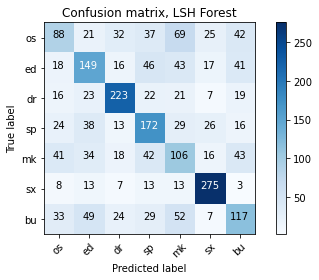

In [28]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(df_results['category'],df_results['lsh_predict'],labels=['os','ed','dr','sp','mk','sx','bu'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mr.plot_confusion_matrix(cnf_matrix, classes=['os','ed','dr','sp','mk','sx','bu'],
                      title='Confusion matrix, LSH Forest')